## 200050147-Kaggle-GNR638

### How to run:
* Open this notebook in kaggle which contains the input data gnr6382021 at the location 'kaggle/input'
* Just keep running each cells 
* Data augmentation and trainging cell may take sometime
* In the last cell a link for 200050147.csv would get generated, simply download the csv on clicking the link

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import tensorflow as tf
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras import layers
from tensorflow.math import add,reduce_mean
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
import tarfile
import os
import shutil
import random
import glob
import cv2
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [8]:
# Frees up the directories before doing data augmentation 
# and rearrangement into directory
if os.path.exists('./gnr_test/'):
    shutil.rmtree('./gnr_test/')
    print('./gnr_test/ removed')
if os.path.exists('./gnr_train/'):
    shutil.rmtree('./gnr_train/')
    print('./gnr_train/ removed')

In [9]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(filename)
        my_tar = tarfile.open(os.path.join(dirname,filename))
        my_tar.extractall('./{}'.format(filename.split(".")[0])) # specify which folder to extract to
        my_tar.close()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

gnr_test.tar.xz
gnr_train.tar.xz


In [11]:
# For Running GPU in kaggle notebook
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [12]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [13]:
# Data Augmentation
for dirname, _, filenames in os.walk('./gnr_train/train'):
    
    # Making the validation directory
    valid_dirname = "/".join(['valid'  if x == 'train' else x for x in dirname.split('/')])
    if not os.path.exists(valid_dirname):
        os.mkdir(valid_dirname)   
    
    j = 0
    for filename in filenames:
        image = np.expand_dims(plt.imread(os.path.join(dirname,filename)),0)
        j +=1
        if j<=45: 
            aug_iter = gen.flow(image, save_to_dir=dirname, save_prefix='aug-image-', save_format='jpg')
            for i in range(10):
                aug_iter.next()
        else: 
            valid_iter = gen.flow(image, save_to_dir=valid_dirname, save_prefix='aug-image-', save_format='jpg')
            for i in range(10):
                valid_iter.next()

In [14]:
# Nesting the gnr_test directory with the unknown directory for data generation
os.mkdir('./gnr_test/unknown')
def moveAllFilesinDir(srcDir, dstDir):
    # Check if both the are directories
    if os.path.isdir(srcDir) and os.path.isdir(dstDir) :
        # Iterate over all the files in source directory
        for filePath in glob.glob(srcDir + '/*'):
            # Move each file to destination Directory
            shutil.move(filePath, dstDir);
    else:
        print("srcDir & dstDir should be Directories")

moveAllFilesinDir('./gnr_test/','./gnr_test/unknown/')

In [15]:
## Train/Valid/Test batch formation and preprocessing of batches for resnet50
train_path = './gnr_train/train'
valid_path = './gnr_train/valid'
test_path = './gnr_test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['basketball_court','bridge','crosswalk','golf_course','oil_well',
'overpass','railway','runway','swimming_pool','tennis_court'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['basketball_court','bridge','crosswalk','golf_course','oil_well',
'overpass','railway','runway','swimming_pool','tennis_court'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=None, class_mode=None, batch_size=10, shuffle=False)

Found 4893 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 100 images belonging to 1 classes.


In [16]:
assert train_batches.n == 4893
assert valid_batches.n == 500
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == 10
assert test_batches.num_classes == 1

In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

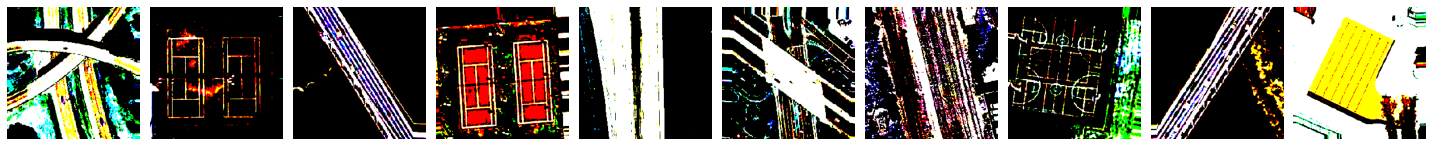

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [21]:
train_images, train_labels = next(train_batches)
plotImages(train_images)
print(train_labels)

In [22]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)

    return X

In [23]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding = 'valid', kernel_initializer = 'glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training) # Default axis
    
    # Final step: 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


In [24]:
def ResNet50(input_shape, classes):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512]) 
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = 'glorot_uniform')(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [26]:
model = ResNet50((224,224,3),10)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 112, 112, 64) 256         conv2d_53[0][0]                  
____________________________________________________________________________________________

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    verbose=2
)

2021-09-20 11:31:30.105526: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-20 11:31:30.110068: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000150000 Hz


Epoch 1/20


2021-09-20 11:31:34.510279: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-20 11:31:35.272227: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-20 11:31:35.298221: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


490/490 - 48s - loss: 1.4755 - accuracy: 0.5876 - val_loss: 1.0423 - val_accuracy: 0.7200
Epoch 2/20
490/490 - 36s - loss: 0.6680 - accuracy: 0.8263 - val_loss: 0.8828 - val_accuracy: 0.8160
Epoch 3/20
490/490 - 36s - loss: 0.3445 - accuracy: 0.9046 - val_loss: 0.5073 - val_accuracy: 0.8820
Epoch 4/20
490/490 - 36s - loss: 0.2272 - accuracy: 0.9366 - val_loss: 0.4838 - val_accuracy: 0.8740
Epoch 5/20
490/490 - 36s - loss: 0.1345 - accuracy: 0.9604 - val_loss: 0.3513 - val_accuracy: 0.9080
Epoch 6/20
490/490 - 36s - loss: 0.2251 - accuracy: 0.9418 - val_loss: 0.4658 - val_accuracy: 0.8840
Epoch 7/20
490/490 - 36s - loss: 0.1800 - accuracy: 0.9548 - val_loss: 0.3985 - val_accuracy: 0.8940
Epoch 8/20
490/490 - 36s - loss: 0.1509 - accuracy: 0.9579 - val_loss: 0.3151 - val_accuracy: 0.9240
Epoch 9/20
490/490 - 36s - loss: 0.0979 - accuracy: 0.9698 - val_loss: 0.3370 - val_accuracy: 0.9220
Epoch 10/20
490/490 - 36s - loss: 0.0734 - accuracy: 0.9783 - val_loss: 0.3503 - val_accuracy: 0.9220


In [34]:
model.save('/kaggle/working/model.h5')
from IPython.display import FileLink
FileLink(r'model.h5')

In [30]:
predictions = model.predict(x=test_batches, verbose=2)
predictions = np.round(predictions)

10/10 - 1s


In [33]:
import csv

class_labels = np.argmax(predictions, axis = -1)

with open('200050147.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(['ImageID','LabelID'])
    for i in range(100):
        writer.writerow([str(101 + i),class_labels[i]+1])
        
FileLink(r'200050147.csv')

[200050147.csv](https://www.kaggle.com/submissions/22899102/22899102.raw)